In [1]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os

In [2]:
models = tf.contrib.keras.models
layers = tf.contrib.keras.layers
initializers = tf.contrib.keras.initializers
regularizers = tf.contrib.keras.regularizers
losses = tf.contrib.keras.losses
optimizers = tf.contrib.keras.optimizers 
metrics = tf.contrib.keras.metrics
preprocessing_image = tf.contrib.keras.preprocessing.image

In [3]:
def residual_block(input_tensor, filters, stage, reg=0.0, use_shortcuts=True):

    bn_name = 'bn' + str(stage)
    conv_name = 'conv' + str(stage)
    relu_name = 'relu' + str(stage)
    merge_name = 'merge' + str(stage)

    # 1x1 conv
    # batchnorm-relu-conv
    # from input_filters to bottleneck_filters
    if stage>1: # first activation is just after conv1
        x = layers.BatchNormalization(name=bn_name+'a')(input_tensor)
        x = layers.Activation('relu', name=relu_name+'a')(x)
    else:
        x = input_tensor

    x = layers.Convolution2D(
            filters[0], (1,1),
            kernel_regularizer=regularizers.l2(reg),
            use_bias=False,
            name=conv_name+'a'
        )(x)

    # 3x3 conv
    # batchnorm-relu-conv
    # from bottleneck_filters to bottleneck_filters
    x = layers.BatchNormalization(name=bn_name+'b')(x)
    x = layers.Activation('relu', name=relu_name+'b')(x)
    x = layers.Convolution2D(
            filters[1], (3,3),
            padding='same',
            kernel_regularizer=regularizers.l2(reg),
            use_bias = False,
            name=conv_name+'b'
        )(x)

    # 1x1 conv
    # batchnorm-relu-conv
    # from bottleneck_filters  to input_filters
    x = layers.BatchNormalization(name=bn_name+'c')(x)
    x = layers.Activation('relu', name=relu_name+'c')(x)
    x = layers.Convolution2D(
            filters[2], (1,1),
            kernel_regularizer=regularizers.l2(reg),
            name=conv_name+'c'
        )(x)

    # merge output with input layer (residual connection)
    if use_shortcuts:
        x = layers.add([x, input_tensor], name=merge_name)

    return x

In [4]:
def ResNetPreAct(input_shape=(32,32,3), nb_classes=5, num_stages=5,
                 use_final_conv=False, reg=0.0):


    # Input
    img_input = layers.Input(shape=input_shape)

    #### Input stream ####
    # conv-BN-relu-pool
    x = layers.Convolution2D(
            128, (3,3), strides=(2, 2),
            padding='same',
            kernel_regularizer=regularizers.l2(reg),
            use_bias=False,
            name='conv0'
        )(img_input)
    x = layers.BatchNormalization(name='bn0')(x)
    x = layers.Activation('relu', name='relu0')(x)
#     x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='pool0')(x)

    #### Residual Blocks ####
    # 1x1 conv: batchnorm-relu-conv
    # FxF conv: batchnorm-relu-conv
    # 1x1 conv: batchnorm-relu-conv
    for stage in range(1,num_stages+1):
        x = residual_block(x, [32,32,128], stage=stage, reg=reg)


    #### Output stream ####
    # BN-relu-(conv)-avgPool-softmax
    x = layers.BatchNormalization(name='bnF')(x)
    x = layers.Activation('relu', name='reluF')(x)

    # Optional final conv layer
    if use_final_conv:
        x = layers.Convolution2D(
                64, (3,3),
                padding='same',
                kernel_regularizer=regularizers.l2(reg),
                name='convF'
            )(x)
    
    pool_size = input_shape[0] / 2
    x = layers.AveragePooling2D((pool_size,pool_size),name='avg_pool')(x)

    x = layers.Flatten(name='flat')(x)
    x = layers.Dense(nb_classes, activation='softmax', name='fc10')(x)

    return models.Model(img_input, x, name='rnpa')

In [5]:
model = ResNetPreAct()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 128)  3456        input_1[0][0]                    
__________________________________________________________________________________________________
bn0 (BatchNormalization)        (None, 16, 16, 128)  512         conv0[0][0]                      
__________________________________________________________________________________________________
relu0 (Activation)              (None, 16, 16, 128)  0           bn0[0][0]                        
__________________________________________________________________________________________________
conv1a (Co

# Compile Model

In [6]:
def compile_model(model):
    
    # loss
    loss = losses.categorical_crossentropy
    
    # optimizer
    optimizer = optimizers.Adam(lr=0.0001)
    
    # metrics
    metric = [metrics.categorical_accuracy, metrics.top_k_categorical_accuracy]
    
    # compile model with loss, optimizer, and evaluation metrics
    model.compile(optimizer, loss, metric)
    
    return model

# Image Preprocessing And Augmentation

In [7]:
train_datagen = preprocessing_image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

test_datagen = preprocessing_image.ImageDataGenerator(rescale=1./255)

In [8]:
BASE_DIR = ""

train_generator = train_datagen.flow_from_directory(
    os.path.join(BASE_DIR, "flower_dataset/train"),
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    os.path.join(BASE_DIR, "flower_dataset/validation"),
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical')

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [9]:
model = ResNetPreAct(input_shape=(32, 32, 3), nb_classes=5, num_stages=5,
                     use_final_conv=False, reg=0.005)

model = compile_model(model)

# Train Model on Flower Dataset

In [10]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=20)

Epoch 1/10
100/100 [==============================] - 14s 141ms/step - loss: 4.6876 - categorical_accuracy: 0.3832 - top_k_categorical_accuracy: 1.0000 - val_loss: 4.7598 - val_categorical_accuracy: 0.2531 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/10
100/100 [==============================] - 8s 81ms/step - loss: 4.2735 - categorical_accuracy: 0.5322 - top_k_categorical_accuracy: 1.0000 - val_loss: 4.5790 - val_categorical_accuracy: 0.2531 - val_top_k_categorical_accuracy: 1.0000
Epoch 3/10
100/100 [==============================] - 8s 82ms/step - loss: 3.9847 - categorical_accuracy: 0.5672 - top_k_categorical_accuracy: 1.0000 - val_loss: 4.4562 - val_categorical_accuracy: 0.2531 - val_top_k_categorical_accuracy: 1.0000
Epoch 4/10
100/100 [==============================] - 8s 81ms/step - loss: 3.7248 - categorical_accuracy: 0.5970 - top_k_categorical_accuracy: 1.0000 - val_loss: 4.2316 - val_categorical_accuracy: 0.2672 - val_top_k_categorical_accuracy: 1.0000
Epoch 5/10
100/100

# Plot Accuracy And Loss Over Time

In [11]:
def plot_accuracy_and_loss(history):
    plt.figure(1, figsize= (15, 10))
    
    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('ResNet accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # plot train and test loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('ResNet loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.savefig("ResNet.jpg")
    plt.show()

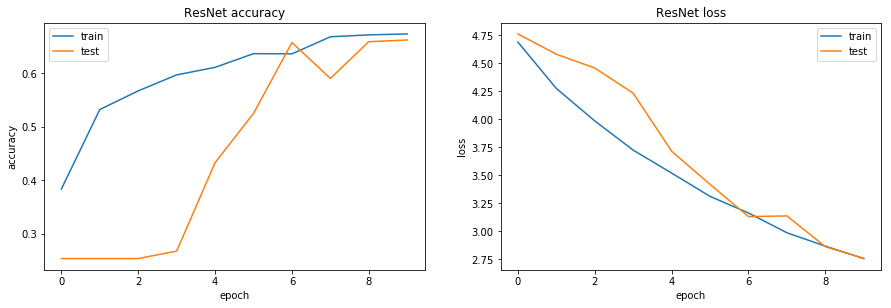

In [12]:
plot_accuracy_and_loss(history)

# Save Model Weights And Configuration


In [13]:
# save model architecture
model_json = model.to_json()
open('resnet_model.json', 'w').write(model_json)

# save model's learned weights
model.save_weights('image_classifier_resnet.h5', overwrite=True)